# Visualize the four base proximity graphs in 2D

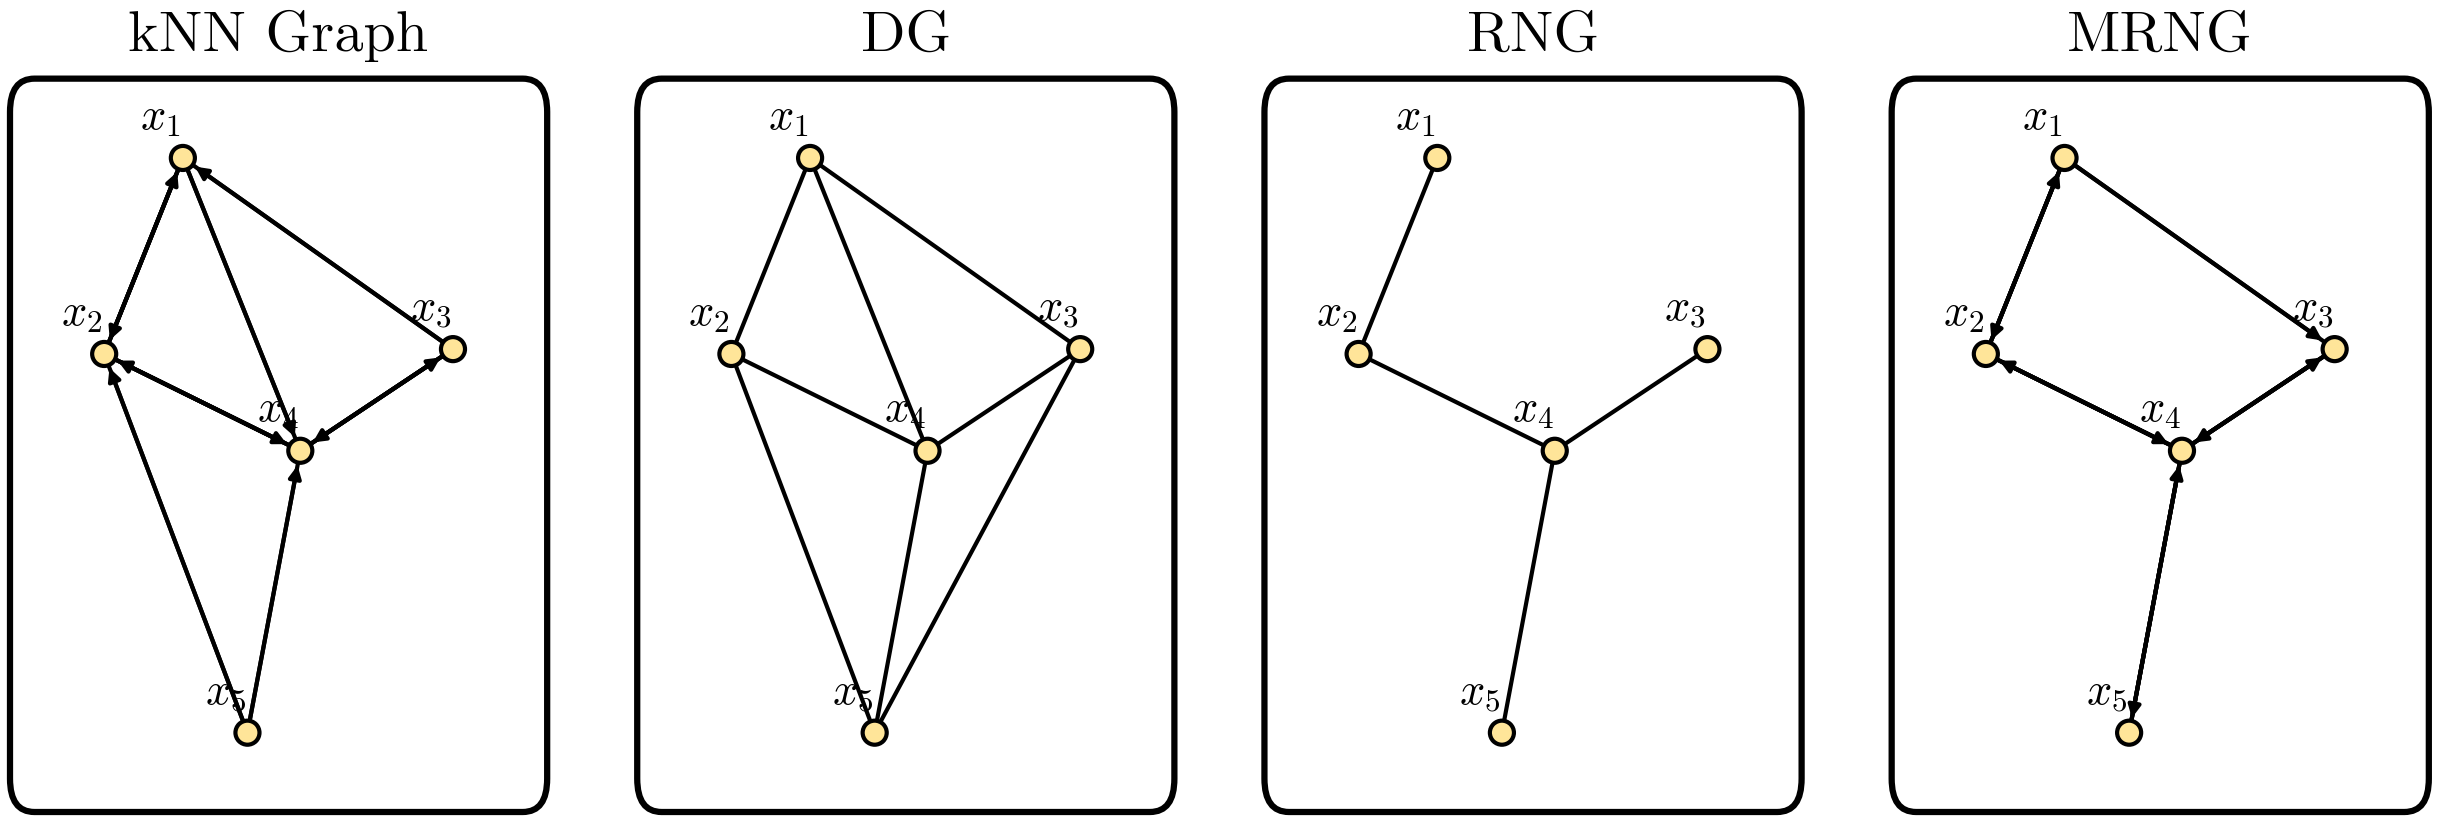

In [4]:
from plot import plot_graphs
from graphs import GraphKind, build_graphs
from utils import create_coords

coords = create_coords([[12.3,-3.6],[5.6,-19.8],[35.3,-19.4],[22.3,-27.8],[17.8,-51.1]])

# gdf: your GeoDataFrame with a 'features' column and point 'geometry'
# Build all graph kinds (base + DEG) with a chosen edges_per_vertex
all_kinds = [GraphKind.KNN, GraphKind.DG, GraphKind.RNG, GraphKind.MRNG]
graphs = build_graphs(coords, kinds=all_kinds, edges_per_vertex=2)

# Example usage
plot_graphs(graphs=graphs, bg_color="white", text_color="black", vertex_label_size=32, title_size=42, marker_size=300, border_color="black", border_padding_x=20, edge_width=3, max_per_row=4, save_file="base_proximity_graphs.pdf")

# Colorize the edges of DEG based on the base graphs

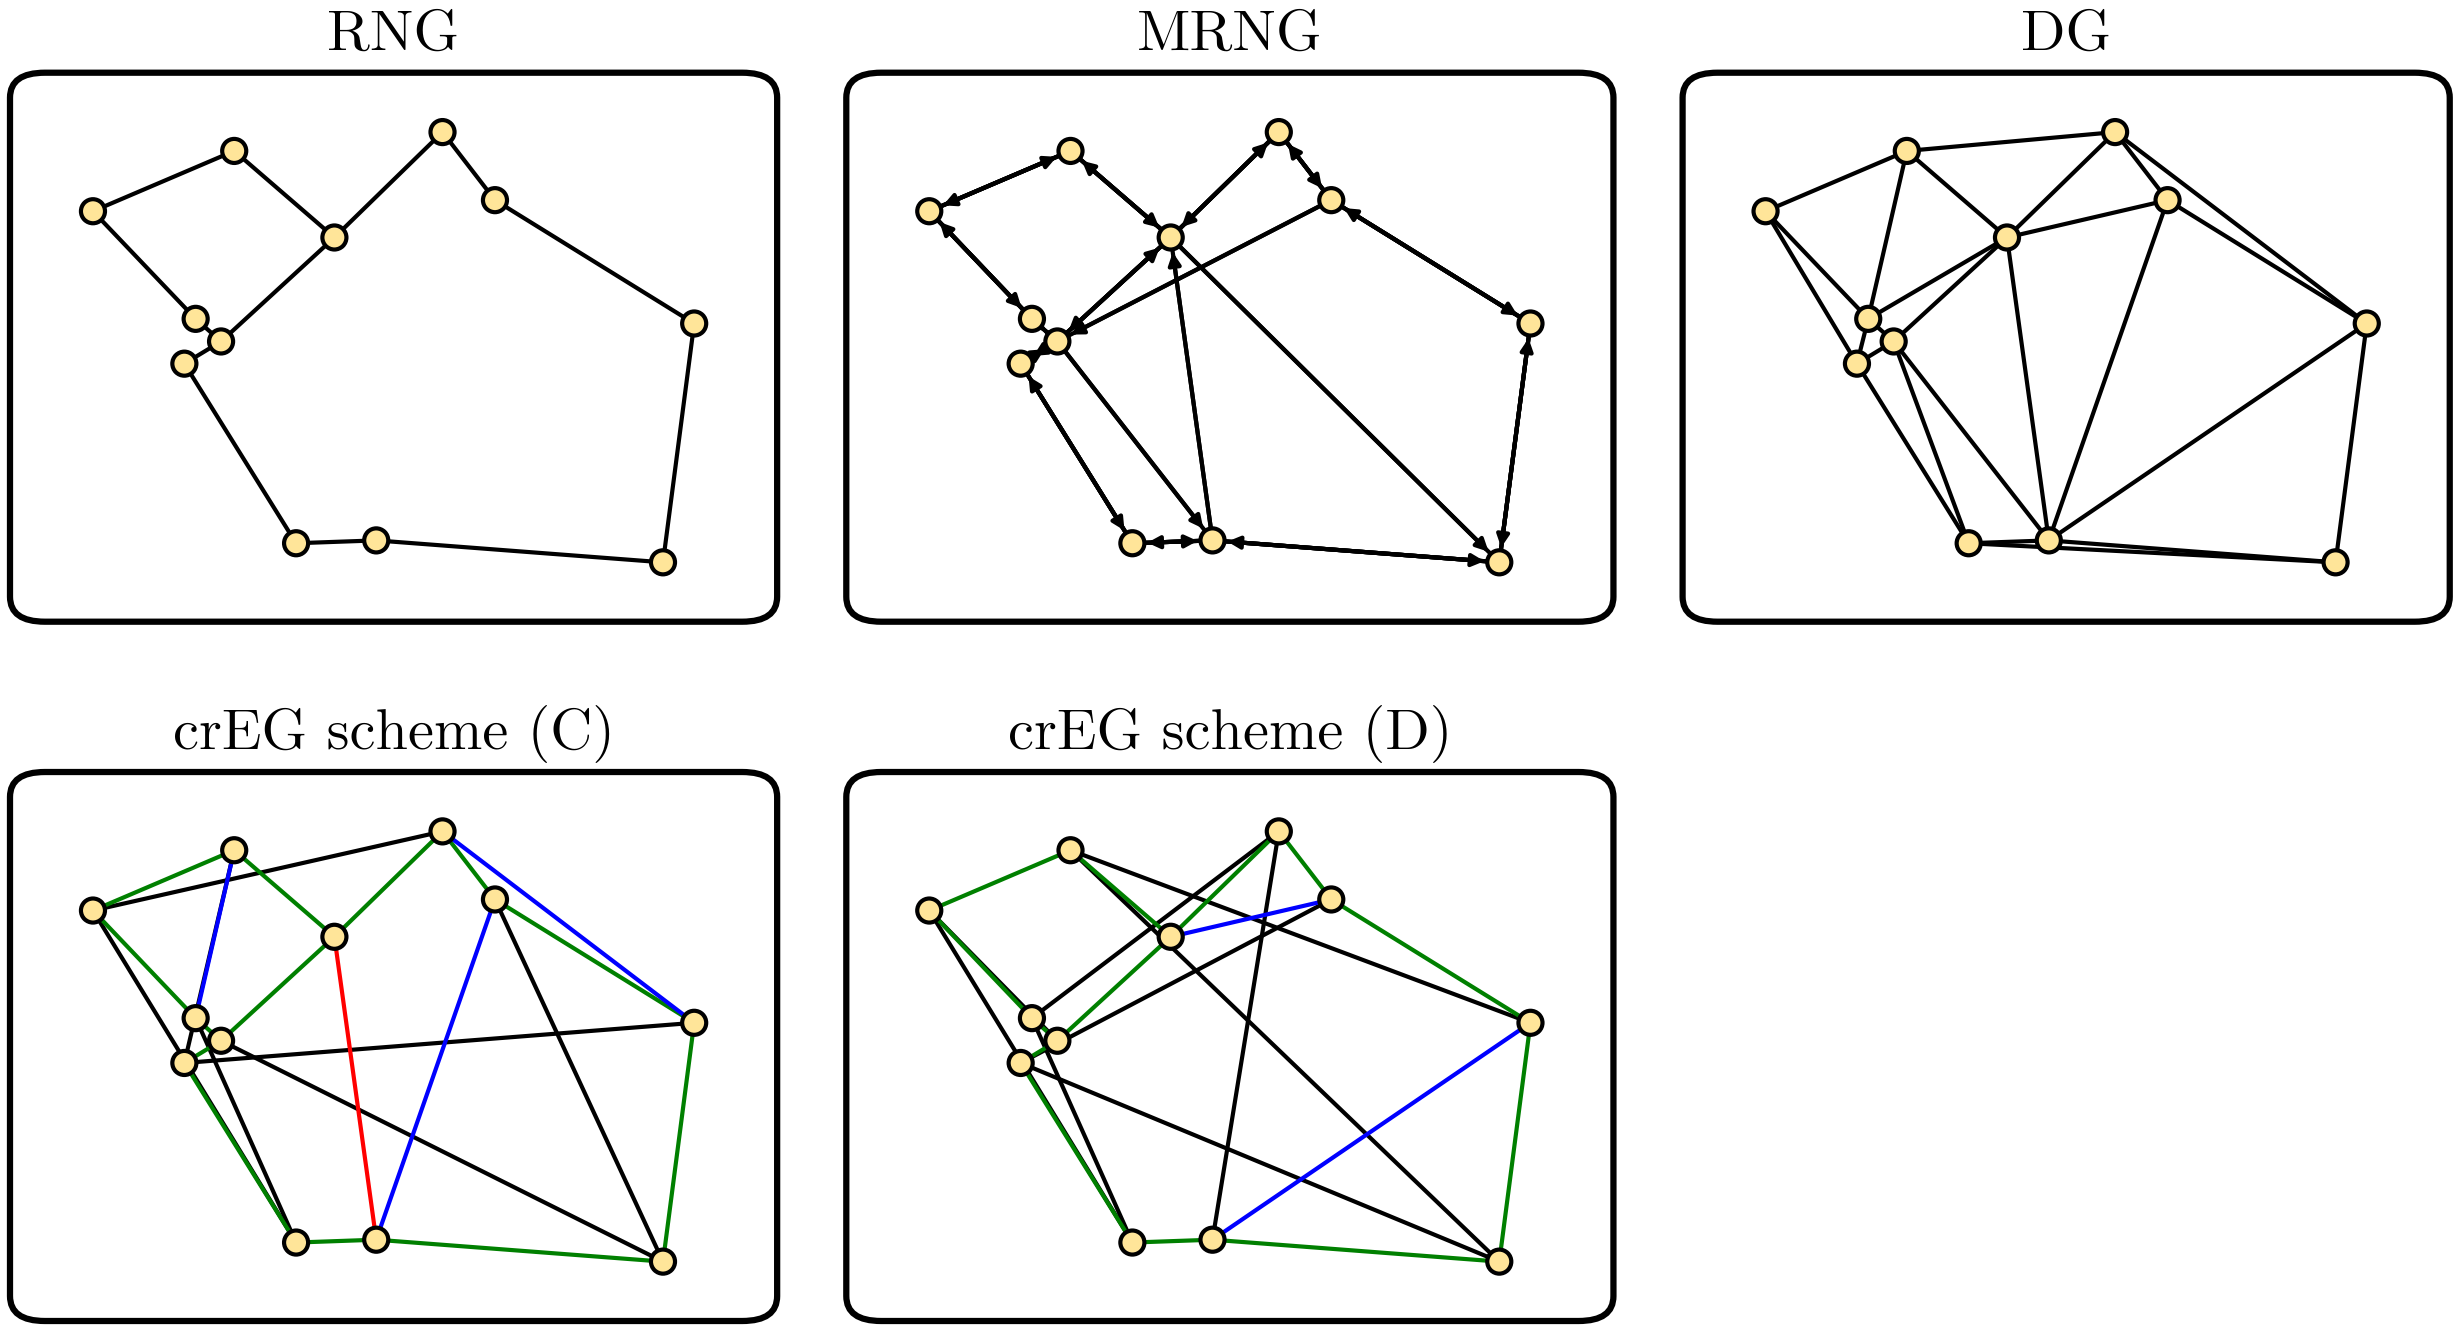

In [3]:
from plot import plot_graphs
from utils import create_random_coords
from graphs import GraphItem, GraphKind, build_graphs
from evaluate import color_overlapping_edges

def color_graph(deg, dg, mrng, rng):
    colored_edges = deg.edges.copy()
    color_overlapping_edges(dg.edges, colored_edges, color="blue", inplace=True)
    color_overlapping_edges(mrng.edges, colored_edges, color="red", inplace=True)
    color_overlapping_edges(rng.edges, colored_edges, color="green", inplace=True)

    # Sync back to the GraphItem so plots reflect the updated colors
    return GraphItem(deg.kind, deg.title, False, deg.vertices, colored_edges)

graph_kinds = [GraphKind.DG, GraphKind.MRNG, GraphKind.RNG, GraphKind.DEGStream, GraphKind.DEGHigh, GraphKind.DEGLow]

coords = create_random_coords(n=12, scale=50, seed=7)
graphs = build_graphs(coords, kinds=graph_kinds, edges_per_vertex=4)

colored_stream_edges = color_graph(graphs[3], graphs[0], graphs[1], graphs[2])
colored_high_edges = color_graph(graphs[4], graphs[0], graphs[1], graphs[2])
colored_low_edges = color_graph(graphs[5], graphs[0], graphs[1], graphs[2])

colored_graphs = [graphs[2], graphs[1], graphs[0], colored_low_edges, colored_high_edges]
plot_graphs(graphs=colored_graphs, bg_color="white", text_color="black", vertex_label_size=0, title_size=42, marker_size=300, border_color="black", edge_width=3, max_per_row=3, save_file="crEG_edges_colored.pdf")

# Visualize the crEG basics

C:\Users\Neiko\miniconda3\envs\city2graph\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


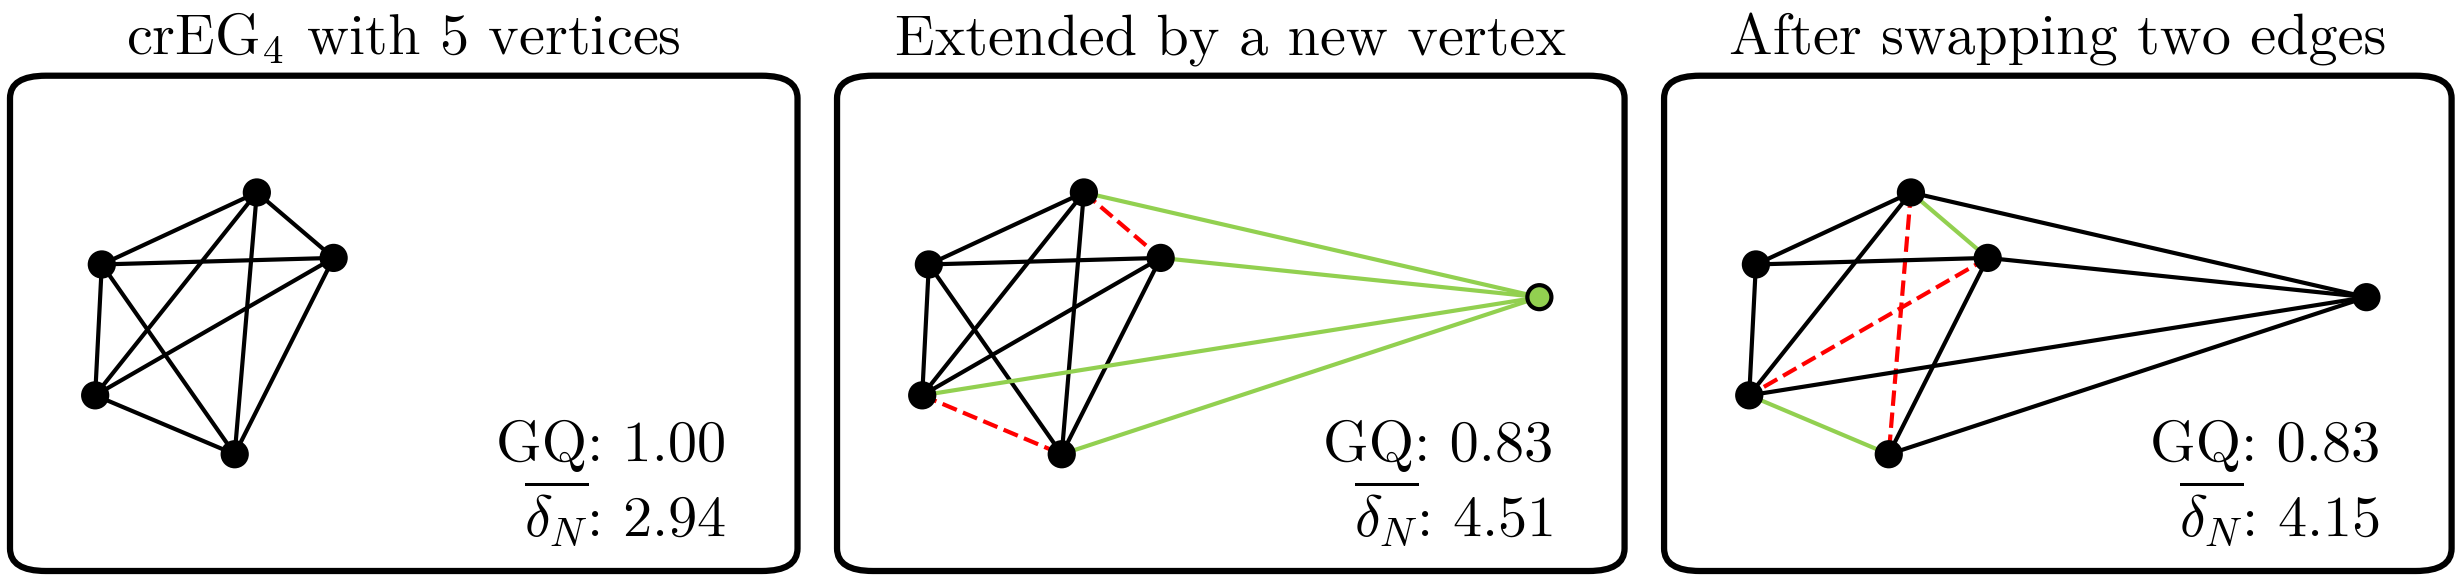

In [1]:
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString
from graphs import GraphItem
from plot import plot_graphs
from utils import create_coords

# Helper function to create a GeoDataFrame for edges.
def create_edges_gdf(coords_df, edges_spec):
    """
    Create a GeoDataFrame for edges from a specification list.
    edges_spec: list of (source_id, target_id, color, linestyle) tuples.
    """
    rows = []
    coords_list = [np.array(p.coords[0]) for p in coords_df['geometry']]
    for src, tgt, color, linestyle in edges_spec:
        p1 = coords_list[src]
        p2 = coords_list[tgt]
        geom = LineString([p1, p2])
        weight = np.linalg.norm(p1 - p2)
        rows.append({
            'source': src,
            'target': tgt,
            'geometry': geom,
            'weight': weight,
            'color': color,
            'linestyle': linestyle
        })
    return gpd.GeoDataFrame(rows, columns=['source', 'target', 'geometry', 'weight', 'color', 'linestyle'])


# --- Shared Data ---
# Define vertex coordinates to match the visual layout
coords = [
    (2.39, 5-0.24),    # 0: top
    (0.29, 5-1.34),    # 1: mid-left
    (3.43, 5-1.24),    # 2: mid-right
    (0.2, 5-3.34),    # 3: bottom-left
    (2.09, 5-4.24),    # 4: bottom-right
    (8.56, 5-1.84)   # 5: new vertex (far right)
]
light_green = '#92d050'
red_color = '#ff0000'

# --- Graph 1: "DEG4 with 5 vertices" ---
vertices1 = create_coords(coords[0:5])
vertices1['color'] = 'black'
k5_edges_spec = [(i, j, 'black', 'solid') for i in range(5) for j in range(i + 1, 5)]
edges1 = create_edges_gdf(vertices1, k5_edges_spec)

graph1 = GraphItem(
    kind=None,
    is_directed=False,
    title=r"crEG$_4$ with 5 vertices",
    vertices=vertices1,
    edges=edges1,
    annotations=["GQ: 1.00", r"$\overline{\delta_N}$: 2.94"]
)

# --- Graph 2: "Extended by a new vertex" ---
vertices2 = create_coords(coords)
vertices2['color'] = 'black'
vertices2.loc[5, 'color'] = light_green
edges2_spec = [spec for spec in k5_edges_spec if (spec[0], spec[1]) != (0, 2) and (spec[0], spec[1]) != (3, 4)]
edges2_spec.append((0, 2, red_color, 'dashed'))
edges2_spec.append((3, 4, red_color, 'dashed'))
for target_id in [0, 2, 3, 4]:
    edges2_spec.append((5, target_id, light_green, 'solid'))
edges2 = create_edges_gdf(vertices2, edges2_spec)

graph2 = GraphItem(
    kind=None,
    is_directed=False,
    title="Extended by a new vertex",
    vertices=vertices2,
    edges=edges2,
    annotations=["GQ: 0.83", r"$\overline{\delta_N}$: 4.51"]
)

# --- Graph 3: "After swapping two edges" ---
vertices3 = create_coords(coords)
vertices3['color'] = 'black'
edges3_spec = [
    (0, 4, red_color, 'dashed'), (2, 3, red_color, 'dashed'),
    (0, 2, light_green, 'solid'), (3, 4, light_green, 'solid'),
    (0, 1, 'black', 'solid'), (0, 3, 'black', 'solid'),
    (1, 2, 'black', 'solid'), (1, 3, 'black', 'solid'), (2, 4, 'black', 'solid'),
    (5, 0, 'black', 'solid'), (5, 3, 'black', 'solid'),
    (5, 2, 'black', 'solid'), (5, 4, 'black', 'solid'),
]
edges3 = create_edges_gdf(vertices3, edges3_spec)

graph3 = GraphItem(
    kind=None,
    is_directed=False,
    title="After swapping two edges",
    vertices=vertices3,
    edges=edges3,
    annotations=["GQ: 0.83", r"$\overline{\delta_N}$: 4.15"]
)

# --- Plot all graphs ---
all_graphs = [graph1, graph2, graph3]
plot_graphs(graphs=all_graphs, bg_color="white", text_color="black", vertex_label_size=0, annotation_size=42, title_size=42, marker_size=300, border_color="black", border_padding_y=36, edge_width=3, max_per_row=3, save_file="crEG_basics.pdf")

# Visualize the crEG extending

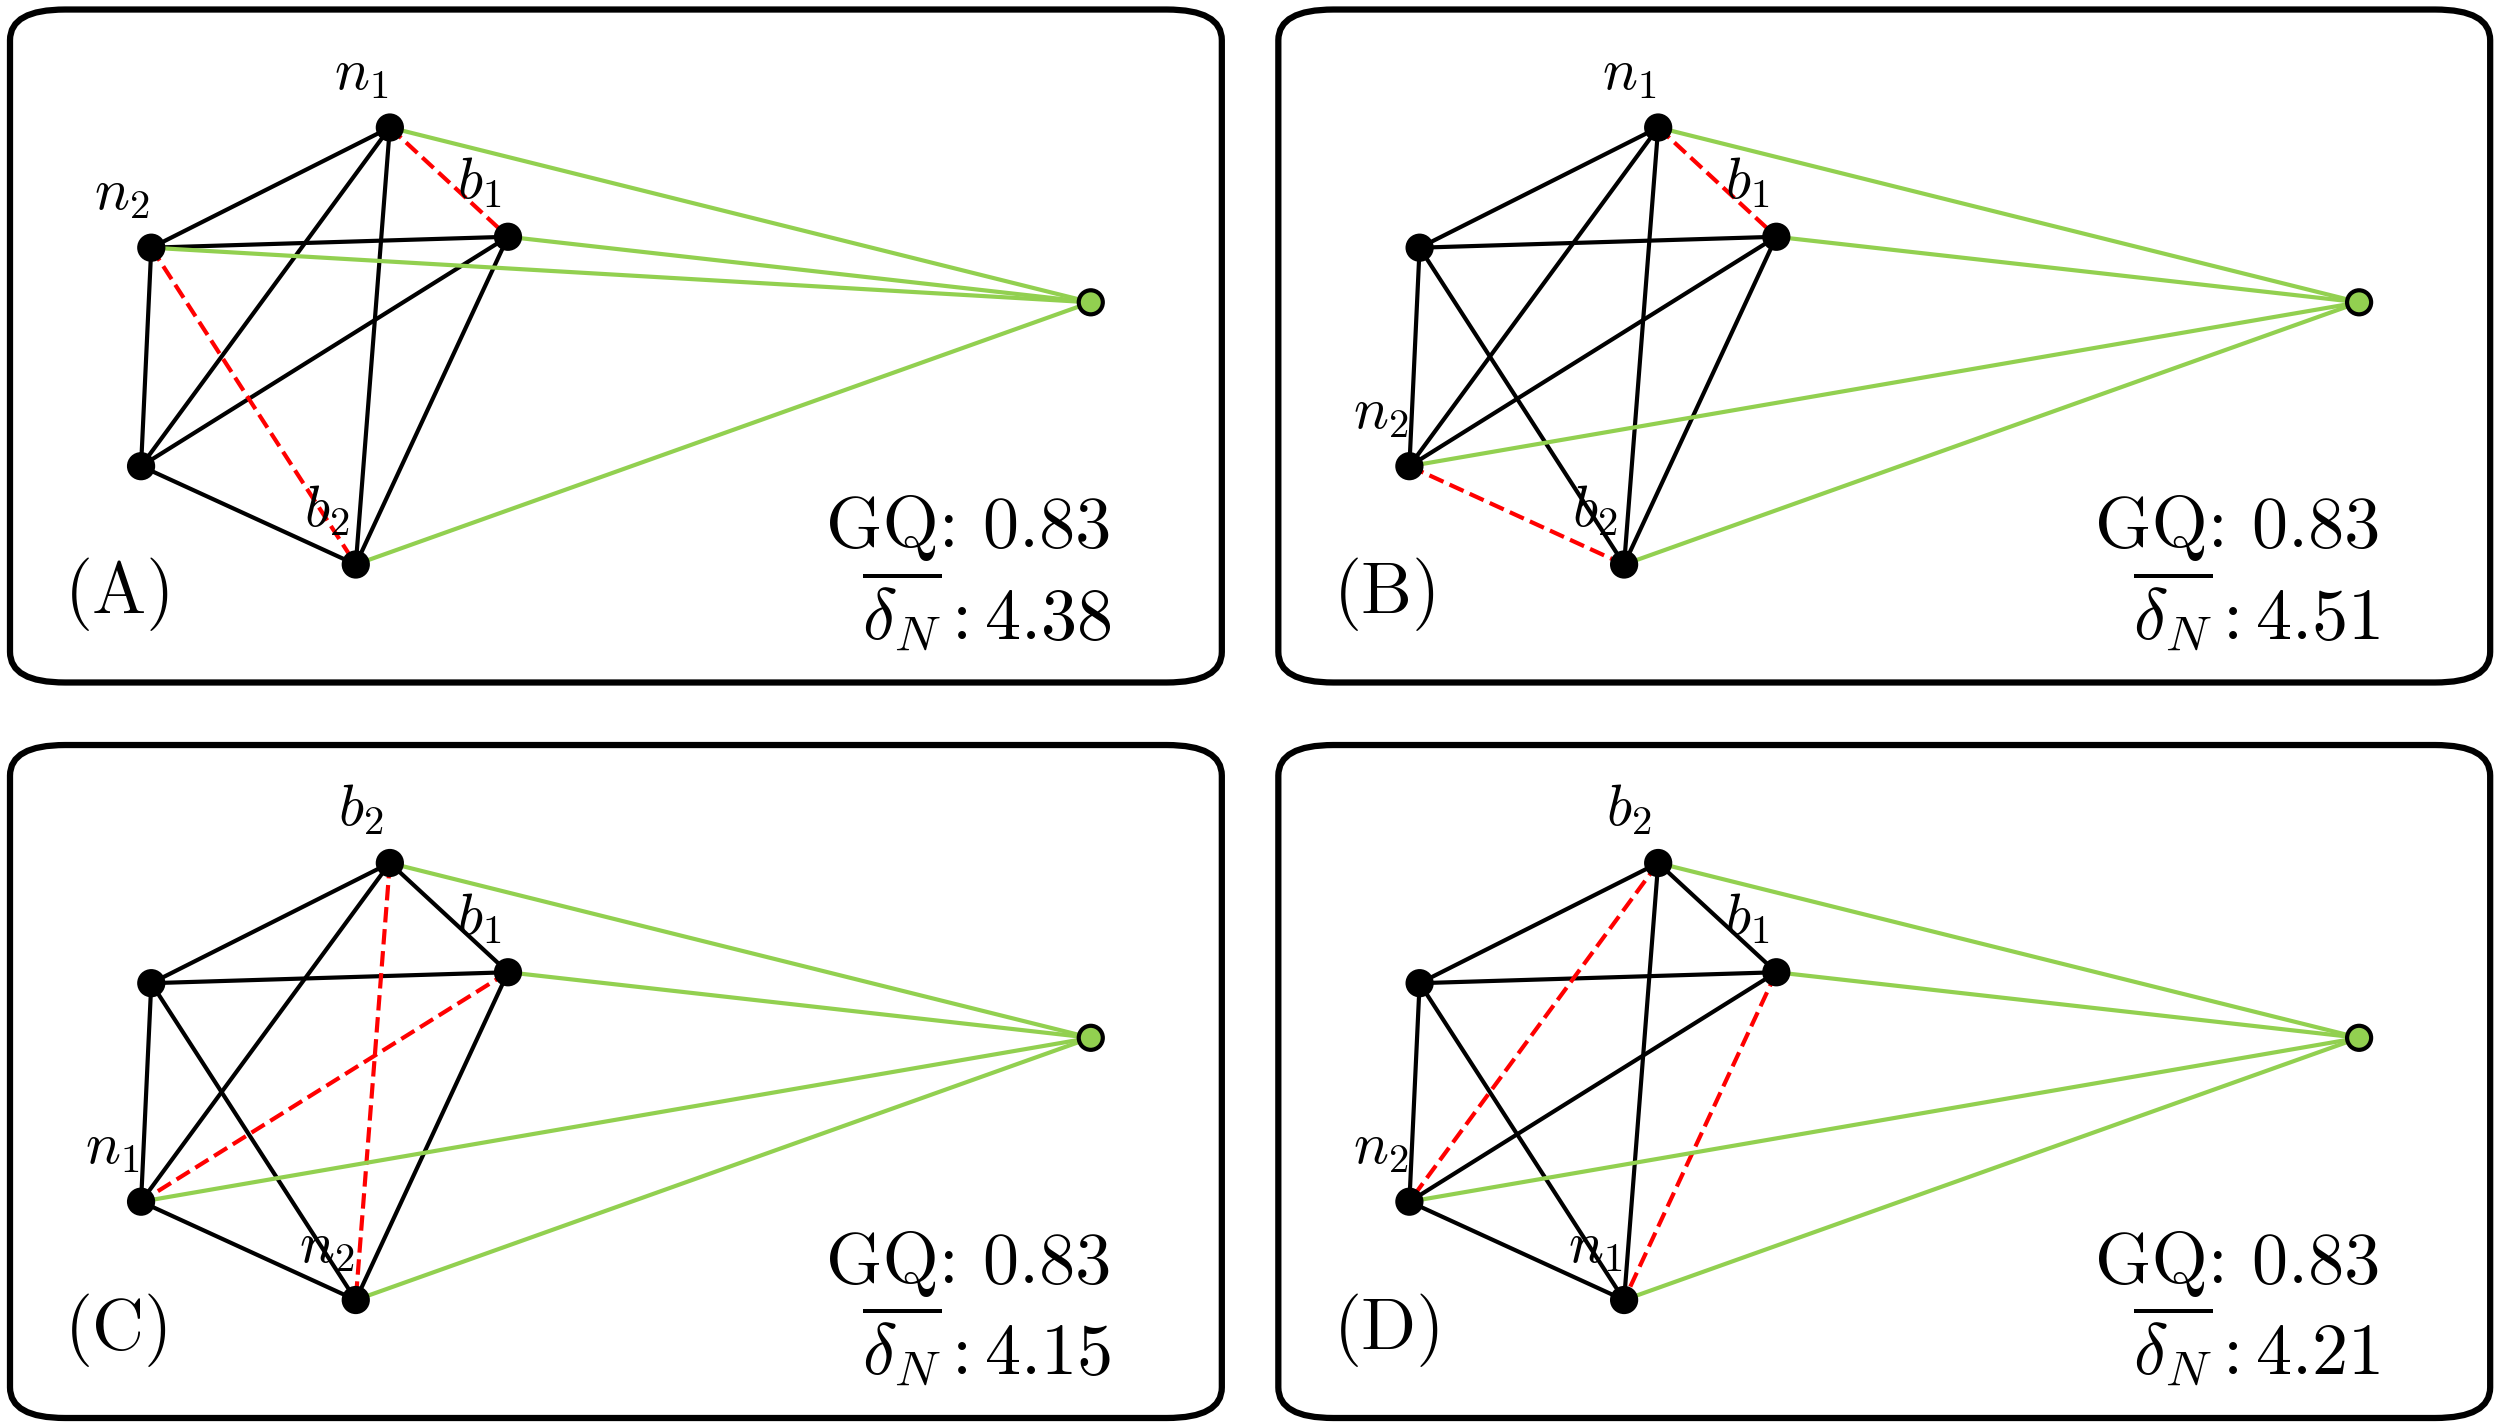

In [4]:
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np

from graphs import GraphItem
from plot import plot_graphs
from utils import create_coords

# --------------------------------------------------------------------
# Helper: edges
# --------------------------------------------------------------------
def create_edges_gdf(coords_df, edges_spec):
    """
    Create a GeoDataFrame for edges from a specification list.
    edges_spec: list of (source_id, target_id, color, linestyle) tuples.
    """
    rows = []
    coords_list = [np.array(p.coords[0]) for p in coords_df["geometry"]]
    for src, tgt, color, linestyle in edges_spec:
        p1 = coords_list[src]
        p2 = coords_list[tgt]
        geom = LineString([p1, p2])
        weight = np.linalg.norm(p1 - p2)
        rows.append(
            {
                "source": src,
                "target": tgt,
                "geometry": geom,
                "weight": weight,
                "color": color,
                "linestyle": linestyle,
            }
        )
    return gpd.GeoDataFrame(
        rows,
        columns=["source", "target", "geometry", "weight", "color", "linestyle"],
    )


# --------------------------------------------------------------------
# Shared coordinates and colors
# --------------------------------------------------------------------
coords = [
    (2.39, 5 - 0.24),  # 0: top
    (0.29, 5 - 1.34),  # 1: mid-left
    (3.43, 5 - 1.24),  # 2: mid-right
    (0.20, 5 - 3.34),  # 3: bottom-left
    (2.09, 5 - 4.24),  # 4: bottom-right
    (8.56, 5 - 1.84),  # 5: far-right (green vertex)
]

light_green = "#92d050"
red_color = "#ff0000"

# --------------------------------------------------------------------
# Generic builder for one panel
# --------------------------------------------------------------------
def build_panel(label_map, red_pairs, delta_bar, title):
    """
    label_map: dict {vertex_index: LaTeX label string}, indices in {0,...,4}
    red_pairs: list of (u, v) pairs in {0,...,4} for red dashed edges
    delta_bar: float, for the $\\bar{\\delta_N}$ annotation
    title: string, title of the graph
    """
    # vertices
    vertices = create_coords(coords)  # your function, provides 'id'
    vertices["color"] = "black"
    vertices.loc[5, "color"] = light_green

    # override labels
    vertices["id"] = ""  # clear default xi+1 labels
    for idx, lab in label_map.items():
        vertices.loc[idx, "id"] = lab
    vertices.loc[5, "id"] = ""  # green vertex unlabeled

    # adjacency inside K5
    red_pairs_set = {tuple(sorted(p)) for p in red_pairs}
    edges_spec = []
    for i in range(5):
        for j in range(i + 1, 5):
            if (i, j) in red_pairs_set:
                color, style = red_color, "dashed"
            else:
                color, style = "black", "solid"
            edges_spec.append((i, j, color, style))

    # edges from green vertex to the four labelled vertices
    labelled_indices = sorted(label_map.keys())
    for v in labelled_indices:
        edges_spec.append((5, v, light_green, "solid"))

    edges = create_edges_gdf(vertices, edges_spec)

    graph = GraphItem(
        kind=None,
        is_directed=False,
        title=title,
        vertices=vertices,
        edges=edges,
        annotations=[
            "GQ: 0.83",
            rf"$\overline{{\delta_N}}: {delta_bar:.2f}$",
        ],
    )
    return graph


# --------------------------------------------------------------------
# Panels (A)–(D)
# indices: 0 top, 1 mid-left, 2 mid-right, 3 bottom-left, 4 bottom-right
# --------------------------------------------------------------------

# (A) labels and red edges
labels_A = {
    0: r"$n_1$",
    1: r"$n_2$",
    2: r"$b_1$",
    4: r"$b_2$",
}
red_pairs_A = [(0, 2), (1, 4)]
graph_A = build_panel(labels_A, red_pairs_A, delta_bar=4.38, title="(A)")

# (B) labels and red edges
labels_B = {
    0: r"$n_1$",
    3: r"$n_2$",
    2: r"$b_1$",
    4: r"$b_2$",
}
red_pairs_B = [(0, 2), (3, 4)]
graph_B = build_panel(labels_B, red_pairs_B, delta_bar=4.51, title="(B)")

# (C) labels and red edges
labels_C = {
    3: r"$n_1$",
    4: r"$n_2$",
    2: r"$b_1$",
    0: r"$b_2$",
}
red_pairs_C = [(0, 4), (2, 3)]
graph_C = build_panel(labels_C, red_pairs_C, delta_bar=4.15, title="(C)")

# (D) labels and red edges
labels_D = {
    4: r"$n_1$",
    3: r"$n_2$",
    2: r"$b_1$",
    0: r"$b_2$",
}
red_pairs_D = [(0, 3), (2, 4)]
graph_D = build_panel(labels_D, red_pairs_D, delta_bar=4.21, title="(D)")

# --------------------------------------------------------------------
# Plot all four graphs in a 2×2 grid
# (global dashed separators are easier to add later in LaTeX)
# --------------------------------------------------------------------
all_graphs = [graph_A, graph_B, graph_C, graph_D]

plot_graphs(
    graphs=all_graphs,
    bg_color="white",
    text_color="black",
    vertex_label_size=42,
    annotation_size=52,
    title_size=52,
    title_position="bottom-left",
    marker_size=300,
    border_color="black",
    border_padding_y=20,
    edge_width=3,
    max_per_row=2,
    save_file="crEG_add_vertex_example.pdf",
)


 Visualising the edge optimization

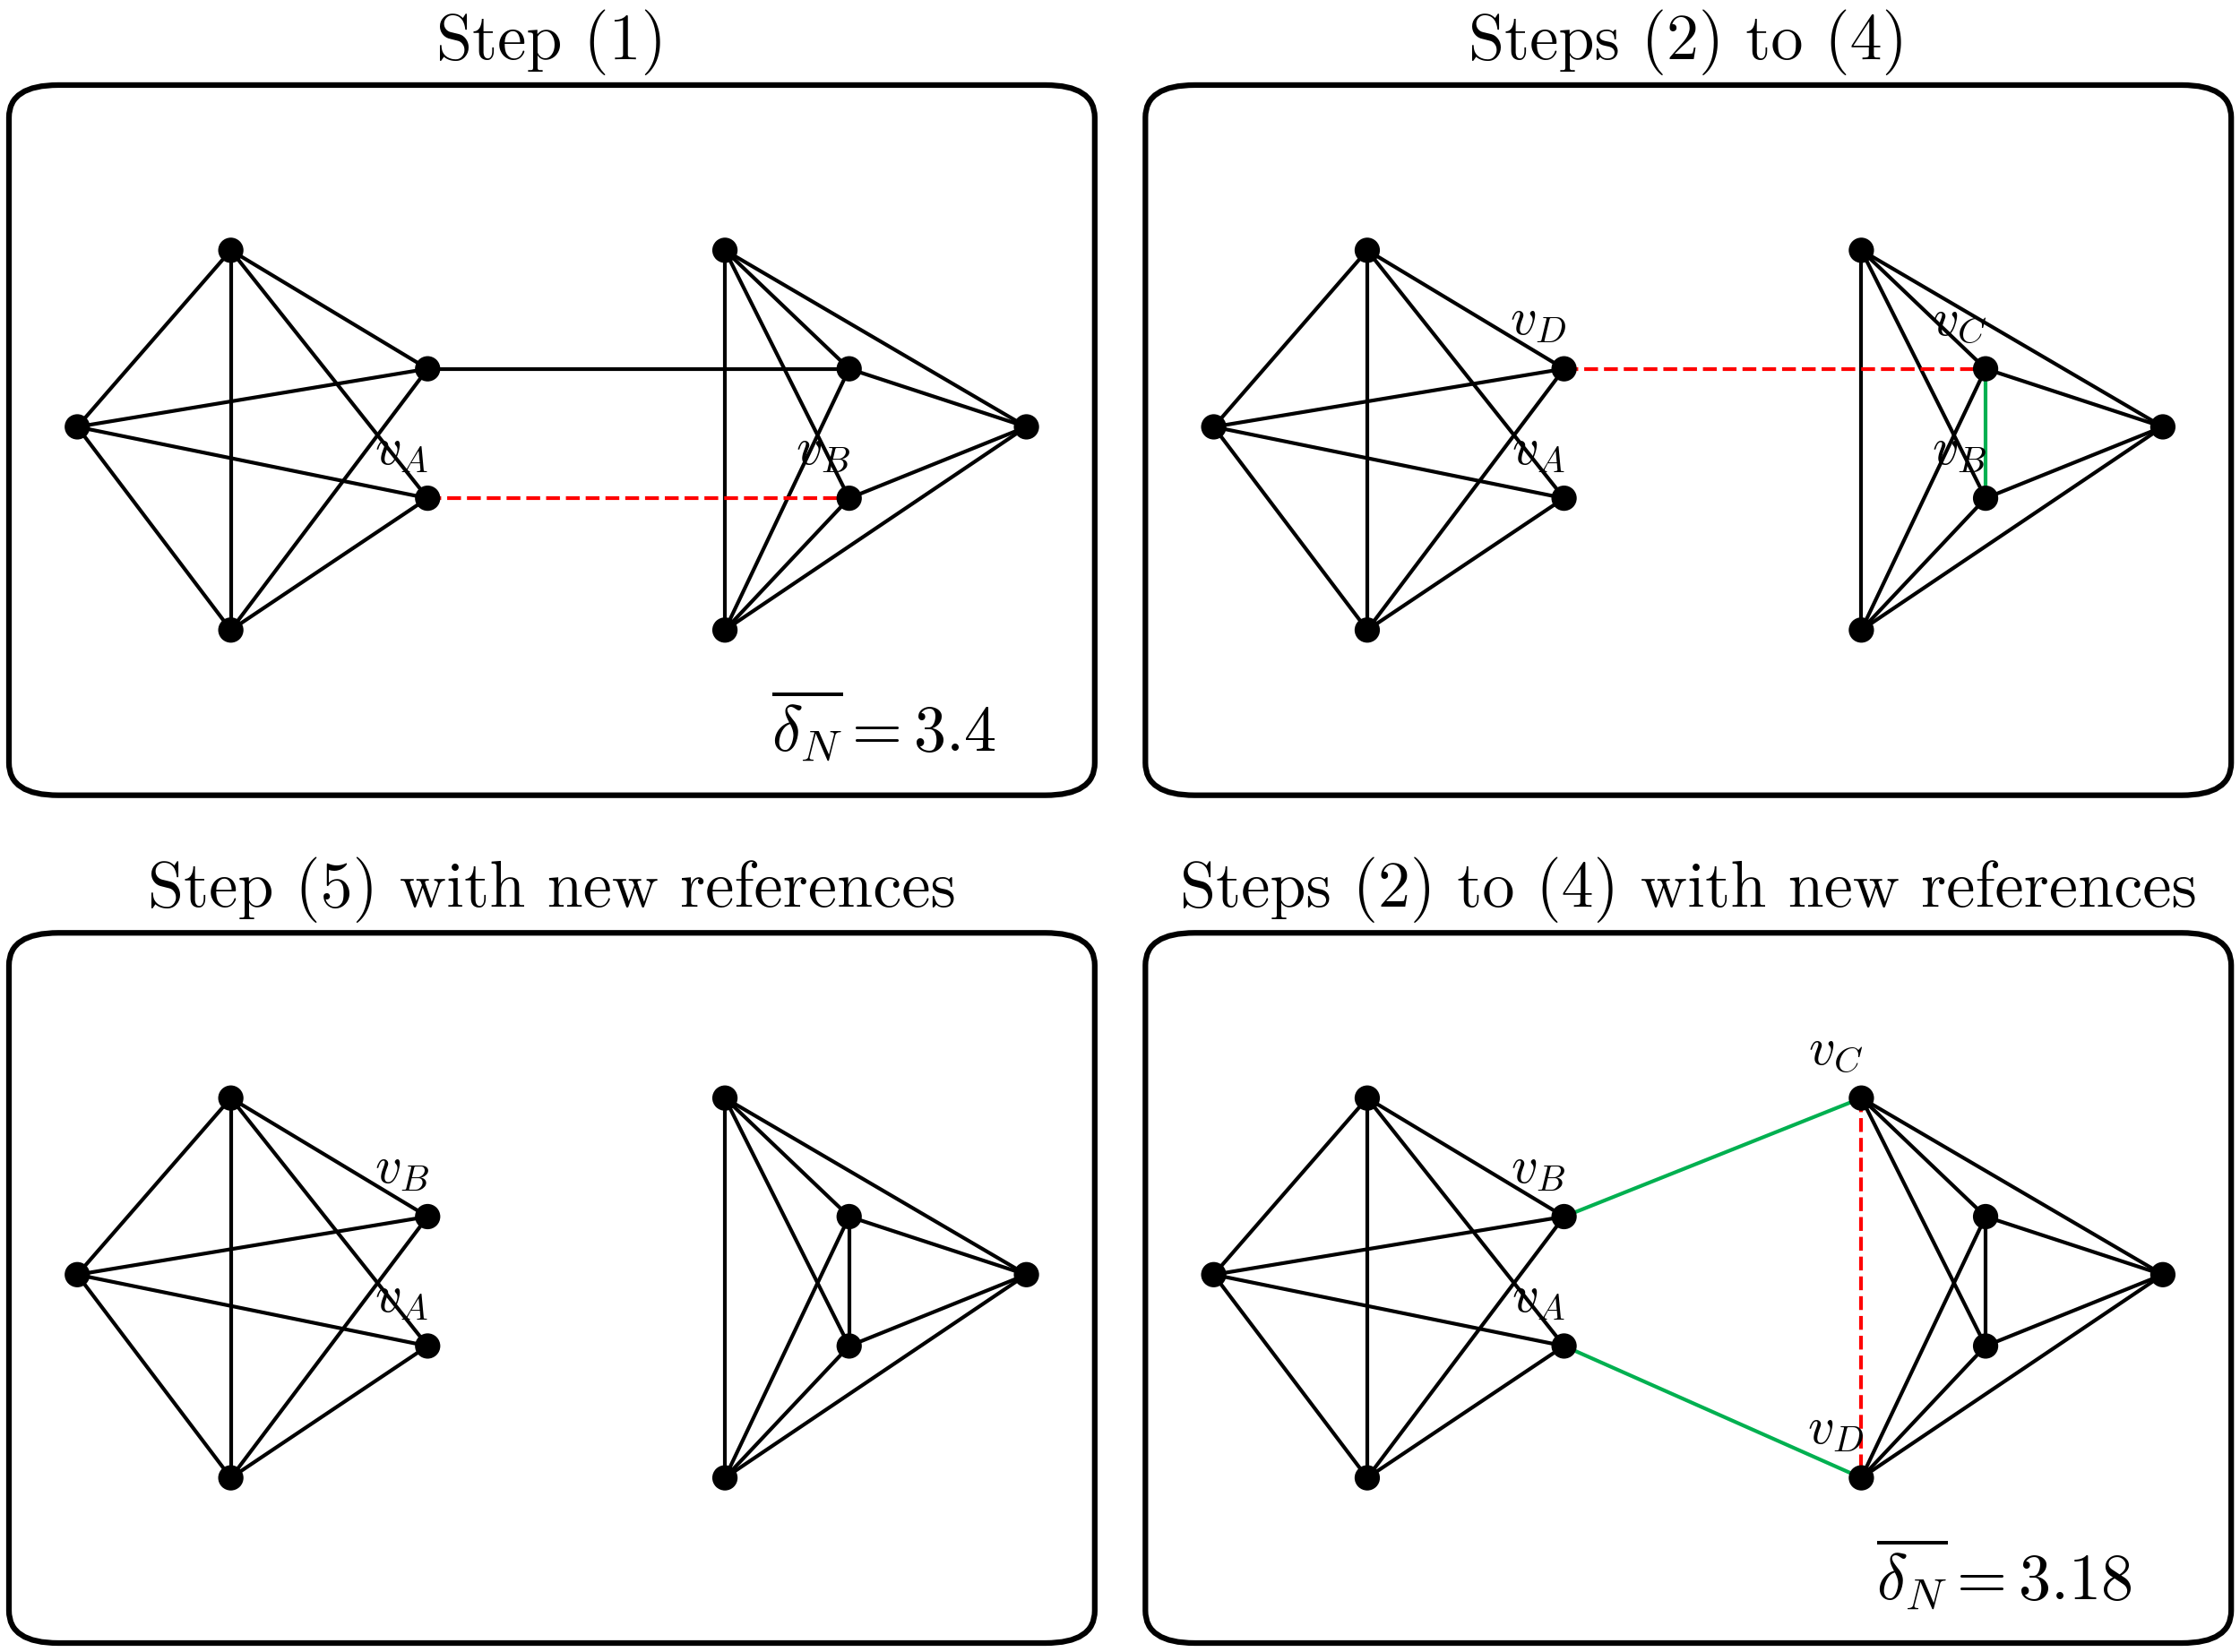

In [3]:
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np
from itertools import combinations

from graphs import GraphItem
from plot import plot_graphs
from utils import create_coords

# --------------------------------------------------------------------
# Helper: edges (provided)
# --------------------------------------------------------------------
def create_edges_gdf(coords_df, edges_spec):
    """
    Create a GeoDataFrame for edges from a specification list.
    edges_spec: list of (source_id, target_id, color, linestyle) tuples.
    """
    rows = []
    coords_list = [np.array(p.coords[0]) for p in coords_df["geometry"]]
    for src, tgt, color, linestyle in edges_spec:
        p1 = coords_list[src]
        p2 = coords_list[tgt]
        geom = LineString([p1, p2])
        weight = np.linalg.norm(p1 - p2)
        rows.append(
            {
                "source": src,
                "target": tgt,
                "geometry": geom,
                "weight": weight,
                "color": color,
                "linestyle": linestyle,
            }
        )
    return gpd.GeoDataFrame(
        rows,
        columns=["source", "target", "geometry", "weight", "color", "linestyle"],
    )

# --------------------------------------------------------------------
# Shared coordinates and colors for 10 vertices (two K5 graphs)
# --------------------------------------------------------------------
# Indices 0-4 for the left K5, 5-9 for the right K5
coords_10 = [
    # Left K5 (0-4)
    (1.57, -0.44),  # 0: Mid-Top
    (0.47, -1.90),  # 1: Leftmost
    (2.98, -1.42),  # 2: Right-top
    (1.57, -3.58),  # 3: Mid-Bottom
    (2.98, -2.49),  # 4: Right-bottom

    # Right K5 (5-9)
    (6.00, -2.49),  # 5: Mid-bottom
    (6.00, -1.42),  # 6: Mid-top
    (5.11, -0.44),  # 7: Left-Top
    (5.11, -3.58),  # 8: Left-Bottom
    (7.27, -1.90),  # 9: Rightmost
]

light_green = "#00b050"
red_color = "#ff0000"
black = "black"

# --------------------------------------------------------------------
# Base edge sets for K5 graphs
# --------------------------------------------------------------------
k5_left_edges = [e for e in combinations(range(5), 2) if e != (2, 4)]
k5_right_edges = [e for e in combinations(range(5, 10), 2) if e != (5, 6)]

# --------------------------------------------------------------------
# Panel 1: Step (1)
# --------------------------------------------------------------------
def build_graph_step1():
    vertices = create_coords(coords_10)
    vertices["color"] = black
    labels = {4: r"$v_A$", 5: r"$v_B$"}
    vertices["id"] = ""
    for idx, lab in labels.items():
        vertices.loc[idx, "id"] = lab

    edges_spec = []
    # All internal edges are black and solid
    for u, v in k5_left_edges + k5_right_edges:
        edges_spec.append((u, v, black, "solid"))
    # Add the solid black bridge between the two components
    edges_spec.append((2, 6, black, "solid")) # Connecting mid-right of left K5 to mid-top of right K5
    # Add the red dashed edge
    edges_spec.append((4, 5, red_color, "dashed")) # Between v_A and v_B

    edges = create_edges_gdf(vertices, edges_spec)
    return GraphItem(
        kind=None,
        is_directed=False,
        title="Step (1)",
        vertices=vertices,
        edges=edges,
        annotations=[r"$\overline{{\delta_N}}=3.4$"],
    )

# --------------------------------------------------------------------
# Panel 2: Steps (2) to (4)
# --------------------------------------------------------------------
def build_graph_step2_4():
    vertices = create_coords(coords_10)
    vertices["color"] = black
    labels = {4: r"$v_A$", 5: r"$v_B$", 6: r"$v_C$", 2: r"$v_D$"}
    vertices["id"] = ""
    for idx, lab in labels.items():
        vertices.loc[idx, "id"] = lab

    # Only internal edges, no connections
    edges_spec = [(u, v, black, "solid") for u, v in k5_left_edges + k5_right_edges]

    # Add green line
    edges_spec.append((5, 6, light_green, "solid")) # Between v_C and v_D

    # Add the external red dashed edge
    edges_spec.append((2, 6, red_color, "dashed")) # Between v_D and v_C

    edges = create_edges_gdf(vertices, edges_spec)
    return GraphItem(
        kind=None,
        is_directed=False,
        title="Steps (2) to (4)",
        vertices=vertices,
        edges=edges,
    )

# --------------------------------------------------------------------
# Panel 3: Step (5) with new references
# --------------------------------------------------------------------
def build_graph_step5():
    vertices = create_coords(coords_10)
    vertices["color"] = black
    labels = {4: r"$v_A$", 2: r"$v_B$"}
    vertices["id"] = ""
    for idx, lab in labels.items():
        vertices.loc[idx, "id"] = lab

    # Only internal edges, no connections
    edges_spec = [(u, v, black, "solid") for u, v in k5_left_edges + k5_right_edges]

    # Black
    edges_spec.append((5, 6, black, "solid"))

    edges = create_edges_gdf(vertices, edges_spec)
    return GraphItem(
        kind=None,
        is_directed=False,
        title="Step (5) with new references",
        vertices=vertices,
        edges=edges,
    )

# --------------------------------------------------------------------
# Panel 4: Steps (2) to (4) with new references
# --------------------------------------------------------------------
def build_graph_step2_4_new():
    vertices = create_coords(coords_10)
    vertices["color"] = black
    labels = {4: r"$v_A$", 2: r"$v_B$", 7: r"$v_C$", 8: r"$v_D$"}
    vertices["id"] = ""
    for idx, lab in labels.items():
        vertices.loc[idx, "id"] = lab

    # Start with all black edges, then modify
    edge_map = {(u, v): (black, "solid") for u, v in k5_left_edges + k5_right_edges}
    # Red dashed edge (recolors an existing internal edge)
    edge_map[tuple(sorted((7, 8)))] = (red_color, "dashed") # Between v_C and v_D

    edges_spec = [(u, v, c, s) for (u, v), (c, s) in edge_map.items()]
    # Add the two green connecting edges
    edges_spec.append((2, 7, light_green, "solid")) # v_B to v_C
    edges_spec.append((4, 8, light_green, "solid")) # v_A to v_D

    # Black
    edges_spec.append((5, 6, black, "solid"))

    edges = create_edges_gdf(vertices, edges_spec)
    return GraphItem(
        kind=None,
        is_directed=False,
        title="Steps (2) to (4) with new references",
        vertices=vertices,
        edges=edges,
        annotations=[r"$\overline{{\delta_N}}=3.18$"],
    )

# --------------------------------------------------------------------
# Generate and plot all four graphs
# --------------------------------------------------------------------
all_graphs = [
    build_graph_step1(),
    build_graph_step2_4(),
    build_graph_step5(),
    build_graph_step2_4_new(),
]

plot_graphs(
    graphs=all_graphs,
    bg_color="white",
    text_color="black",
    vertex_label_size=42,
    annotation_size=52,
    title_size=52,
    title_position="top-center",
    marker_size=300,
    border_padding_x=2,
    border_padding_y=35,
    edge_width=3,
    max_per_row=2,
    save_file="crEG_edge_optimization.pdf",
)